In [1]:
!git clone "https://github.com/jyanivaddi/ERA_V1.git"
!git pull

fatal: destination path 'ERA_V1' already exists and is not an empty directory.
fatal: not a git repository (or any of the parent directories): .git


Add all the imports

In [2]:
from __future__ import print_function
import sys
sys.path.append("ERA_V1/session_9")
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
import albumentations as A
import albumentations.augmentations as AA
from albumentations.pytorch import ToTensorV2
from cifar10.utils import preview_images, plot_statistics, show_incorrect_predictions, get_incorrect_predictions
from cifar10.model import Model_Net, model_summary, model_train, model_test
from cifar10.data_loader import load_cifar10_data

Allocate GPU

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
cifar_10_model = Model_Net(base_channels=3,num_classes=10).to(device)
model_summary(cifar_10_model, input_size=(3,32,32))
#from torchviz import make_dot
#x = torch.zeros(1,3,32,32,dtype=torch.float, requires_grad=False)
#y  = cifar_10_model(x)
#cifar_model_dot = make_dot(y.mean(), params = dict(list(cifar_10_model.named_parameters())))
#cifar_model_dot.format='png'
#cifar_model_dot.render("model_dot_representation.png")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
           Dropout-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
           Dropout-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          36,864
      BatchNorm2d-10           [-1, 64, 32, 32]             128
             ReLU-11           [-1, 64, 32, 32]               0
          Dropout-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 32, 32, 32]          18,432
      BatchNorm2d-14           [-1, 32,

/content/ERA_V1/session_9/cifar10/model.py:215: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Define Transforms

In [4]:
train_transforms = A.Compose(
    [
        A.ShiftScaleRotate(shift_limit = 0.05, scale_limit = 0.05, rotate_limit=10.,p=0.1),
        A.HorizontalFlip(p=0.1),
        AA.dropout.coarse_dropout.CoarseDropout(max_holes = 1, max_height=16,
                                                max_width=16, min_holes = 1,
                                                min_height=16, min_width=16,
                                                fill_value=(0.491, 0.482, 0.447),
                                                mask_fill_value = None),

        A.Normalize(mean=(0.491,0.482,0.447),std=(0.247,0.244,0.262)),
        ToTensorV2(),
    ]
)
test_transforms = A.Compose([
    A.Normalize(mean=(0.491,0.482,0.447),std=(0.247,0.244,0.262)),
    ToTensorV2(),
])

Define train and test loaders

In [5]:
torch.manual_seed(1)
batch_size = 64
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
train_loader, test_loader, class_names = load_cifar10_data(train_transforms, test_transforms, batch_size, **kwargs)

Files already downloaded and verified
Files already downloaded and verified


Show sample Images from the dataset

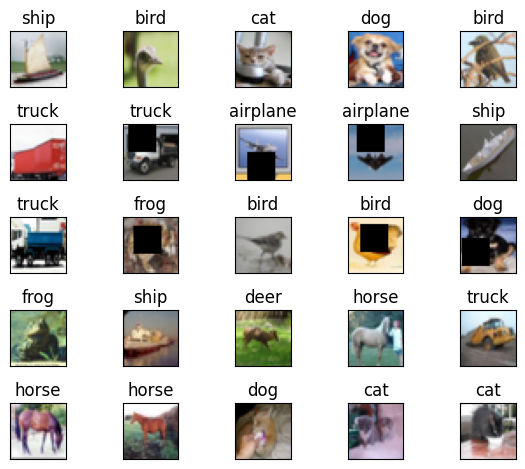

In [6]:
preview_images(train_loader,class_names, num_rows = 5, num_cols = 5)

Train model using Batch Normalization

In [7]:
drop_out = 0.02
num_epochs=40
model_bn = Model_Net(base_channels=3, num_classes=10, drop_out = drop_out).to(device)
optimizer = optim.SGD(model_bn.parameters(), lr=0.01, momentum=0.9)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, threshold=0.1,verbose=True)
train_losses_bn = []
test_losses_bn = []
train_acc_bn = []
test_acc_bn = []

for epoch in range(1,num_epochs+1):
    print(f"epoch: {epoch}")
    this_train_loss = model_train(model_bn, device, train_loader, optimizer, train_acc_bn, train_losses_bn)
    this_loss = model_test(model_bn, device, test_loader, test_acc_bn, test_losses_bn)
    scheduler.step(this_loss)
target_test_acc = 85.


epoch: 1


loss=1.8879344463348389 batch_id=781 Accuracy = 41.44: 100%|██████████| 782/782 [00:29<00:00, 26.52it/s]



Test set: Average loss: 1.2430, Accuracy: 5423/10000 (54.23%)

epoch: 2


loss=0.9549611806869507 batch_id=781 Accuracy = 57.50: 100%|██████████| 782/782 [00:30<00:00, 25.93it/s]



Test set: Average loss: 1.1618, Accuracy: 5998/10000 (59.98%)

epoch: 3


loss=1.1148110628128052 batch_id=781 Accuracy = 63.94: 100%|██████████| 782/782 [00:29<00:00, 26.28it/s]



Test set: Average loss: 0.8681, Accuracy: 6915/10000 (69.15%)

epoch: 4


loss=1.141442894935608 batch_id=781 Accuracy = 68.18: 100%|██████████| 782/782 [00:30<00:00, 25.72it/s]



Test set: Average loss: 0.8328, Accuracy: 7091/10000 (70.91%)

epoch: 5


loss=0.9654721021652222 batch_id=781 Accuracy = 71.20: 100%|██████████| 782/782 [00:30<00:00, 25.80it/s]



Test set: Average loss: 0.7033, Accuracy: 7554/10000 (75.54%)

epoch: 6


loss=0.7682964205741882 batch_id=781 Accuracy = 73.05: 100%|██████████| 782/782 [00:30<00:00, 25.87it/s]



Test set: Average loss: 0.6838, Accuracy: 7624/10000 (76.24%)

epoch: 7


loss=0.8990373611450195 batch_id=781 Accuracy = 74.74: 100%|██████████| 782/782 [00:29<00:00, 26.40it/s]



Test set: Average loss: 0.6821, Accuracy: 7706/10000 (77.06%)

epoch: 8


loss=0.7746365666389465 batch_id=781 Accuracy = 75.77: 100%|██████████| 782/782 [00:30<00:00, 25.91it/s]



Test set: Average loss: 0.5936, Accuracy: 7928/10000 (79.28%)

epoch: 9


loss=1.0922558307647705 batch_id=781 Accuracy = 76.87: 100%|██████████| 782/782 [00:29<00:00, 26.23it/s]



Test set: Average loss: 0.5947, Accuracy: 7953/10000 (79.53%)

epoch: 10


loss=0.47875329852104187 batch_id=781 Accuracy = 77.69: 100%|██████████| 782/782 [00:30<00:00, 25.72it/s]



Test set: Average loss: 0.6697, Accuracy: 7790/10000 (77.90%)

epoch: 11


loss=0.8280353546142578 batch_id=781 Accuracy = 78.66: 100%|██████████| 782/782 [00:30<00:00, 25.91it/s]



Test set: Average loss: 0.5489, Accuracy: 8124/10000 (81.24%)

epoch: 12


loss=0.6686394214630127 batch_id=781 Accuracy = 79.09: 100%|██████████| 782/782 [00:30<00:00, 25.93it/s]



Test set: Average loss: 0.5437, Accuracy: 8160/10000 (81.60%)

epoch: 13


loss=0.28260165452957153 batch_id=781 Accuracy = 79.43: 100%|██████████| 782/782 [00:29<00:00, 26.18it/s]



Test set: Average loss: 0.4996, Accuracy: 8311/10000 (83.11%)

epoch: 14


loss=0.3681330382823944 batch_id=781 Accuracy = 80.26: 100%|██████████| 782/782 [00:30<00:00, 25.92it/s]



Test set: Average loss: 0.5335, Accuracy: 8167/10000 (81.67%)

epoch: 15


loss=0.8132916688919067 batch_id=781 Accuracy = 80.70: 100%|██████████| 782/782 [00:29<00:00, 26.18it/s]



Test set: Average loss: 0.5090, Accuracy: 8270/10000 (82.70%)

epoch: 16


loss=0.8442661166191101 batch_id=781 Accuracy = 81.30: 100%|██████████| 782/782 [00:30<00:00, 25.79it/s]



Test set: Average loss: 0.5039, Accuracy: 8324/10000 (83.24%)

epoch: 17


loss=0.6801868677139282 batch_id=781 Accuracy = 81.65: 100%|██████████| 782/782 [00:29<00:00, 26.40it/s]



Test set: Average loss: 0.5348, Accuracy: 8228/10000 (82.28%)

epoch: 18


loss=0.8147441744804382 batch_id=781 Accuracy = 81.92: 100%|██████████| 782/782 [00:30<00:00, 25.59it/s]



Test set: Average loss: 0.4594, Accuracy: 8466/10000 (84.66%)

Epoch 00018: reducing learning rate of group 0 to 1.0000e-03.
epoch: 19


loss=0.5370935797691345 batch_id=781 Accuracy = 84.62: 100%|██████████| 782/782 [00:29<00:00, 26.07it/s]



Test set: Average loss: 0.4159, Accuracy: 8626/10000 (86.26%)

epoch: 20


loss=0.6205512285232544 batch_id=781 Accuracy = 85.37: 100%|██████████| 782/782 [00:30<00:00, 25.93it/s]



Test set: Average loss: 0.4067, Accuracy: 8636/10000 (86.36%)

epoch: 21


loss=1.1715645790100098 batch_id=781 Accuracy = 85.50: 100%|██████████| 782/782 [00:29<00:00, 26.28it/s]



Test set: Average loss: 0.4038, Accuracy: 8650/10000 (86.50%)

epoch: 22


loss=0.3277246356010437 batch_id=781 Accuracy = 85.63: 100%|██████████| 782/782 [00:30<00:00, 25.82it/s]



Test set: Average loss: 0.4077, Accuracy: 8616/10000 (86.16%)

epoch: 23


loss=0.5734827518463135 batch_id=781 Accuracy = 85.89: 100%|██████████| 782/782 [00:29<00:00, 26.35it/s]



Test set: Average loss: 0.4029, Accuracy: 8645/10000 (86.45%)

epoch: 24


loss=0.7658084630966187 batch_id=781 Accuracy = 86.06: 100%|██████████| 782/782 [00:31<00:00, 25.21it/s]



Test set: Average loss: 0.4064, Accuracy: 8627/10000 (86.27%)

Epoch 00024: reducing learning rate of group 0 to 1.0000e-04.
epoch: 25


loss=0.6397465467453003 batch_id=781 Accuracy = 86.31: 100%|██████████| 782/782 [00:30<00:00, 25.76it/s]



Test set: Average loss: 0.4037, Accuracy: 8656/10000 (86.56%)

epoch: 26


loss=0.8478249311447144 batch_id=781 Accuracy = 86.34: 100%|██████████| 782/782 [00:30<00:00, 25.73it/s]



Test set: Average loss: 0.4033, Accuracy: 8651/10000 (86.51%)

epoch: 27


loss=0.749731719493866 batch_id=781 Accuracy = 86.38: 100%|██████████| 782/782 [00:29<00:00, 26.15it/s]



Test set: Average loss: 0.3996, Accuracy: 8659/10000 (86.59%)

epoch: 28


loss=0.7970629334449768 batch_id=781 Accuracy = 86.46: 100%|██████████| 782/782 [00:30<00:00, 26.03it/s]



Test set: Average loss: 0.4010, Accuracy: 8672/10000 (86.72%)

epoch: 29


loss=0.45345109701156616 batch_id=781 Accuracy = 86.47: 100%|██████████| 782/782 [00:29<00:00, 26.28it/s]



Test set: Average loss: 0.4019, Accuracy: 8656/10000 (86.56%)

Epoch 00029: reducing learning rate of group 0 to 1.0000e-05.
epoch: 30


loss=0.23496414721012115 batch_id=781 Accuracy = 86.33: 100%|██████████| 782/782 [00:30<00:00, 25.37it/s]



Test set: Average loss: 0.3991, Accuracy: 8667/10000 (86.67%)

epoch: 31


loss=0.33518123626708984 batch_id=781 Accuracy = 86.52: 100%|██████████| 782/782 [00:29<00:00, 26.22it/s]



Test set: Average loss: 0.4008, Accuracy: 8651/10000 (86.51%)

epoch: 32


loss=0.45882025361061096 batch_id=781 Accuracy = 86.57: 100%|██████████| 782/782 [00:29<00:00, 26.25it/s]



Test set: Average loss: 0.3982, Accuracy: 8673/10000 (86.73%)

epoch: 33


loss=0.6805887222290039 batch_id=781 Accuracy = 86.71: 100%|██████████| 782/782 [00:29<00:00, 26.33it/s]



Test set: Average loss: 0.4012, Accuracy: 8661/10000 (86.61%)

epoch: 34


loss=0.7214833498001099 batch_id=781 Accuracy = 86.58: 100%|██████████| 782/782 [00:29<00:00, 26.27it/s]



Test set: Average loss: 0.4009, Accuracy: 8652/10000 (86.52%)

Epoch 00034: reducing learning rate of group 0 to 1.0000e-06.
epoch: 35


loss=0.9632033109664917 batch_id=781 Accuracy = 86.65: 100%|██████████| 782/782 [00:30<00:00, 25.78it/s]



Test set: Average loss: 0.4003, Accuracy: 8659/10000 (86.59%)

epoch: 36


loss=0.6741652488708496 batch_id=781 Accuracy = 86.40: 100%|██████████| 782/782 [00:29<00:00, 26.27it/s]



Test set: Average loss: 0.3997, Accuracy: 8670/10000 (86.70%)

epoch: 37


loss=0.6453557014465332 batch_id=781 Accuracy = 86.62: 100%|██████████| 782/782 [00:30<00:00, 25.25it/s]



Test set: Average loss: 0.3996, Accuracy: 8677/10000 (86.77%)

epoch: 38


loss=1.0328036546707153 batch_id=781 Accuracy = 86.60: 100%|██████████| 782/782 [00:29<00:00, 26.24it/s]



Test set: Average loss: 0.3999, Accuracy: 8668/10000 (86.68%)

epoch: 39


loss=0.7086344361305237 batch_id=781 Accuracy = 86.58: 100%|██████████| 782/782 [00:30<00:00, 25.74it/s]



Test set: Average loss: 0.4023, Accuracy: 8648/10000 (86.48%)

Epoch 00039: reducing learning rate of group 0 to 1.0000e-07.
epoch: 40


loss=0.6052601933479309 batch_id=781 Accuracy = 86.50: 100%|██████████| 782/782 [00:29<00:00, 26.29it/s]



Test set: Average loss: 0.4007, Accuracy: 8658/10000 (86.58%)



Plot results for Batch Norm experiment

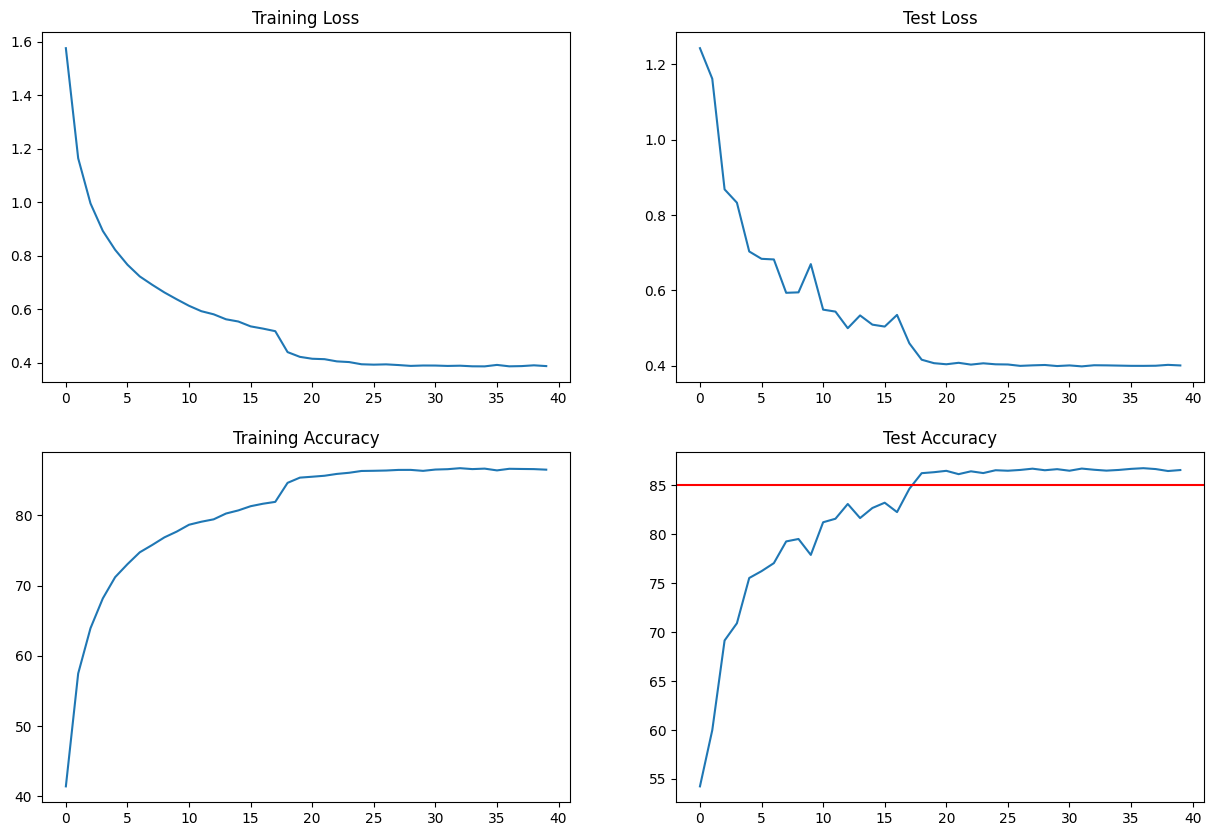

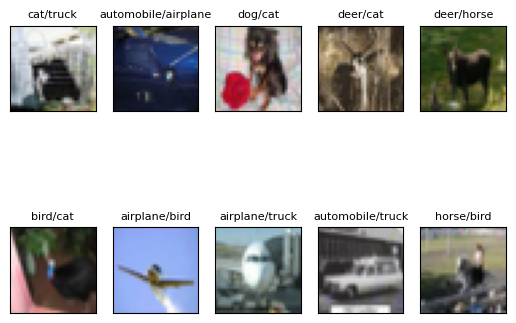

In [8]:
plot_statistics(train_losses_bn, train_acc_bn, test_losses_bn, test_acc_bn, target_test_acc)
incorrect_predictions_bn = get_incorrect_predictions(model_bn, test_loader, device)
show_incorrect_predictions(incorrect_predictions_bn, class_names, num_rows = 2, num_cols = 5)